In [1]:
# Add parent dir to path for utils access
import sys, os
sys.path.append(os.path.dirname(os.path.abspath('')))

# Import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import rasterio 
import rioxarray as rio
import cf_xarray
import earthaccess
import utilities.useful_functions as utils
from rasterio.enums import Resampling

# Set up known scenes and time to search through
bboxes = {"mb":(-102, 53.5, -92, 59), "la":(-120, 32, -116, 36)}
tspan = ("2024-12-07", "2024-12-19")

In [2]:
# Set credentials
auth = earthaccess.login(persist=True)

In [3]:
# Grabbing LA pre-fire granules
# Cloud cover is whole granule, so must look at worldview to choose
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_SFREFL",
    temporal=tspan,
    bounding_box=bboxes["la"],
    cloud_cover=(0, 75)
)

Granules found: 14


In [4]:
# Grab two specific prefire granules 
# (had to worldview it for clear sky over LA)
results = [results[0], results[-1]]
paths = earthaccess.open(results)
paths

Opening 2 granules, approx size: 1.46 GB


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20241207T203537.L2.SFREFL.V3_0.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20241218T202231.L2.SFREFL.V3_0.nc>]

In [5]:
# Open, subset, and mask files. Cell takes quite a while
prefire_1, prefire_2 = utils.open_nc(paths[0]), utils.open_nc(paths[1])
prefire_1, prefire_2 = utils.subset(prefire_1, bboxes["la"]), utils.subset(prefire_2, bboxes["la"])
prefire_1, prefire_2 = utils.mask_ds(prefire_1), utils.mask_ds(prefire_2)

/accounts/sacaplan/pace-rapid-response/utilities/useful_functions.py:25: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dt = xr.open_datatree(filename)
/accounts/sacaplan/pace-rapid-response/utilities/useful_functions.py:25: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xar

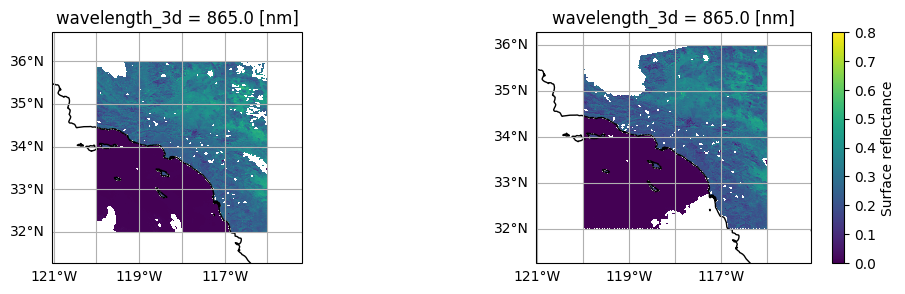

In [6]:
# Plot to make sure 
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,3))
ax[0].coastlines()
ax[1].coastlines()
ax[0].gridlines(draw_labels={"left": "y", "bottom": "x"})
ax[1].gridlines(draw_labels={"left": "y", "bottom": "x"})
prefire_1.rhos[:,:,110].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax[0], add_colorbar=False)
prefire_2.rhos[:,:,110].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax[1])
plt.show()

In [13]:
# Project first prefire granule to get grid
dst = reproject_3d(prefire_1["rhos"])

# Project 2nd with defined grid from above
pf2_dst = reproject_3d(prefire_2["rhos"], 
                             shape=dst.rio.shape, 
                             transform=dst.rio.transform())


TypeError: rasterio.warp.reproject() got multiple values for keyword argument 'src_transform'

In [10]:
dst.rio.shape

(455, 493)

In [13]:
pf2_dst

<xarray.DataArray 'rhos' (wavelength_3d: 122, latitude: 442, longitude: 528)> Size: 114MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * longitude      (longitude) float64 4kB -121.0 -121.0 ... -115.0 -115.0
  * latitude       (latitude) float64 4kB 36.28 36.27 36.26 ... 31.28 31.27
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    spatial_ref    int64 8B 0
Attributes:
    long_name:   Surface reflectance
    valid_min:   -0.05
    valid_max:   1.0
    _FillValue:  nan

In [35]:
if sr_src.dims[0] != "number_of_lines":
    print("number of lines not 1st, works")

number of lines not 1st, works


In [33]:
sr_src.dims[0]

'wavelength_3d'

In [36]:
lst = [1,2,3]
type(lst)

list

In [37]:
if type(lst) == list:
    print(lst)

[1, 2, 3]
